# リポジトリクローン

In [1]:
!git clone https://github.com/facebookresearch/segment-anything-2

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 320 (delta 20), reused 13 (delta 13), pack-reused 271
Receiving objects: 100% (320/320), 42.93 MiB | 21.23 MiB/s, done.
Resolving deltas: 100% (27/27), done.


# 必要パッケージインストール　※インストール後、ランタイムを再起動

In [2]:
%cd segment-anything-2

/content/segment-anything-2


In [3]:
!pip install -e .

Obtaining file:///content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu

#### ランタイム再起動後、ここから実行

In [1]:
%cd segment-anything-2

/content/segment-anything-2


In [2]:
!python setup.py build_ext --inplace

running build_ext
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:499: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:418: UserWarning: The detected CUDA version (12.2) has a minor version mismatch with the version that was used to compile PyTorch (12.1). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:428: UserWarning: There are no x86_64-linux-gnu-g++ version bounds defined for CUDA version 12.2
  warnings.warn(f'There are no {compiler_name} version bounds defined for CUDA version {cuda_str_version}')
building 'sam2._C' extension
creating build
creating build/temp.linux-x86_64-cpython-310
creating build

# 重みダウンロード

In [3]:
%cd /content/segment-anything-2/checkpoints
!./download_ckpts.sh
%cd ../

/content/segment-anything-2/checkpoints
--2024-08-05 12:01:12--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.78, 13.226.210.111, 13.226.210.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155906050 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_tiny.pt’

sam2_hiera_tiny.pt  100%[===================>] 148.68M   157MB/s    in 0.9s    

2024-08-05 12:01:13 (157 MB/s) - ‘sam2_hiera_tiny.pt’ saved [155906050/155906050]

--2024-08-05 12:01:13--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.78, 13.226.210.111, 13.226.210.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.78|:443... connected.
HTTP request sent, awaiting response...

# パッケージインポート

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

/content/segment-anything-2/sam2/modeling/sam/transformer.py:22: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


# 事前設定、表示関連関数 準備

In [5]:
# オートキャスト設定
torch.autocast(device_type="cuda", dtype=torch.float16).__enter__()
if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [6]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

# サンプル画像読み込み

In [7]:
image = Image.open('notebooks/images/truck.jpg')
image = np.array(image.convert("RGB"))

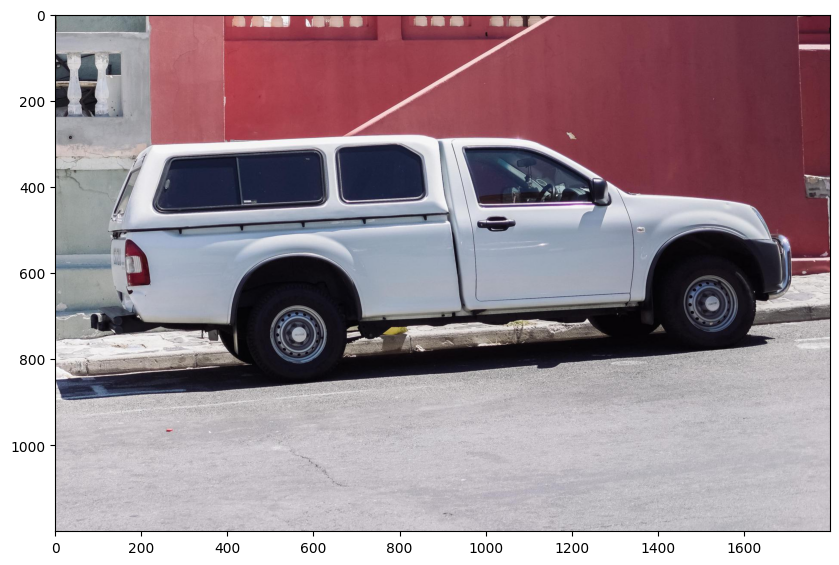

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

# SAM2モデル準備

In [9]:
sam2_checkpoint = "checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)

# 画像設定

In [10]:
predictor.set_image(image)

# 座標1点指定サンプル

In [11]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

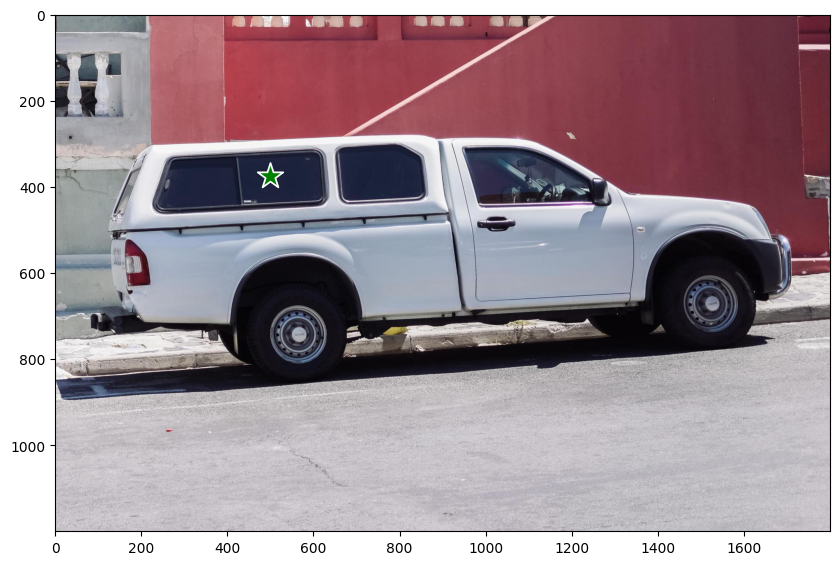

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [13]:
print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


In [14]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

In [15]:
masks.shape  # (number_of_masks) x H x W

(3, 1200, 1800)

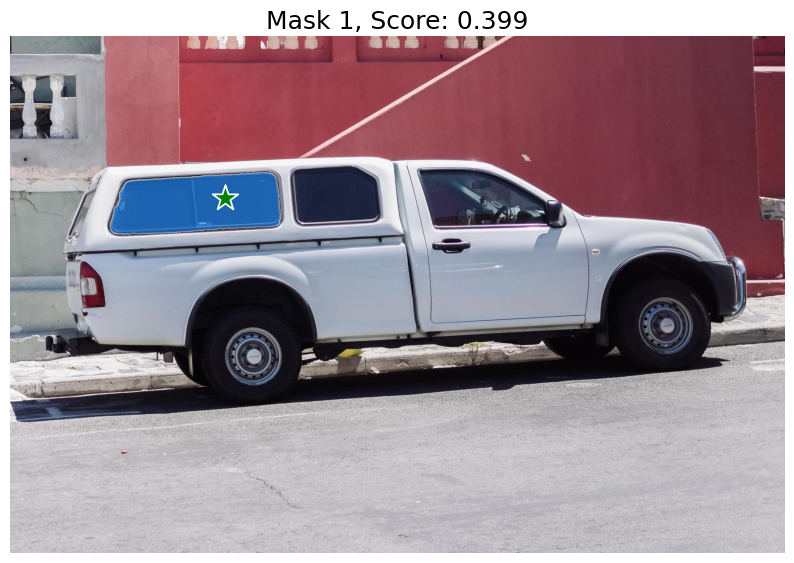

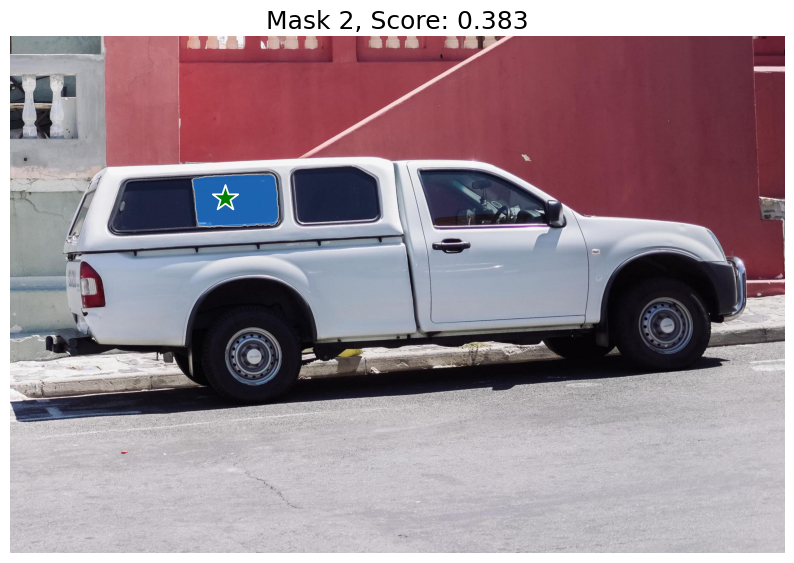

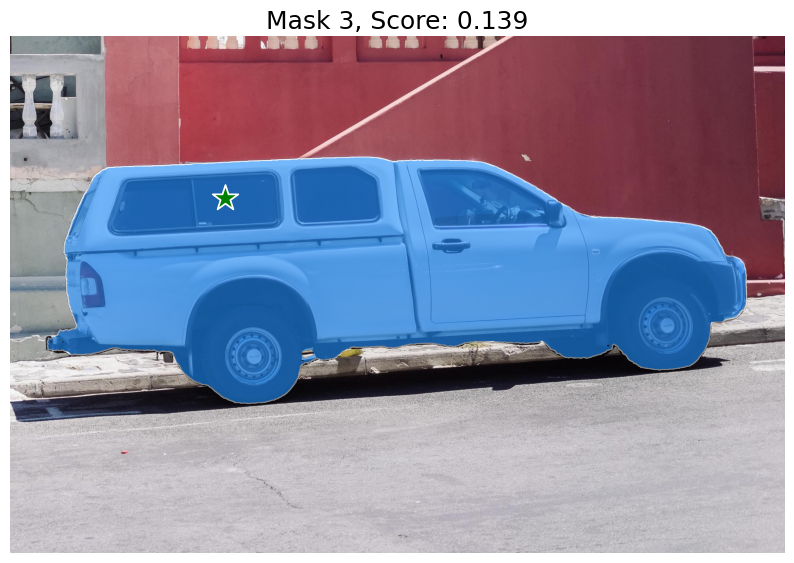

In [16]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

In [17]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [18]:
masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [19]:
masks.shape

(1, 1200, 1800)

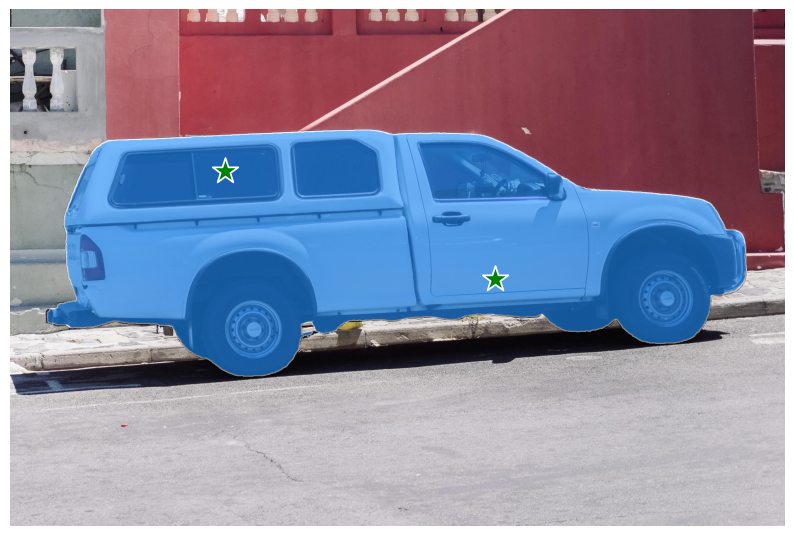

In [20]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)

# 座標2点(対象1点、非対象1点)指定サンプル

In [21]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [22]:
masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

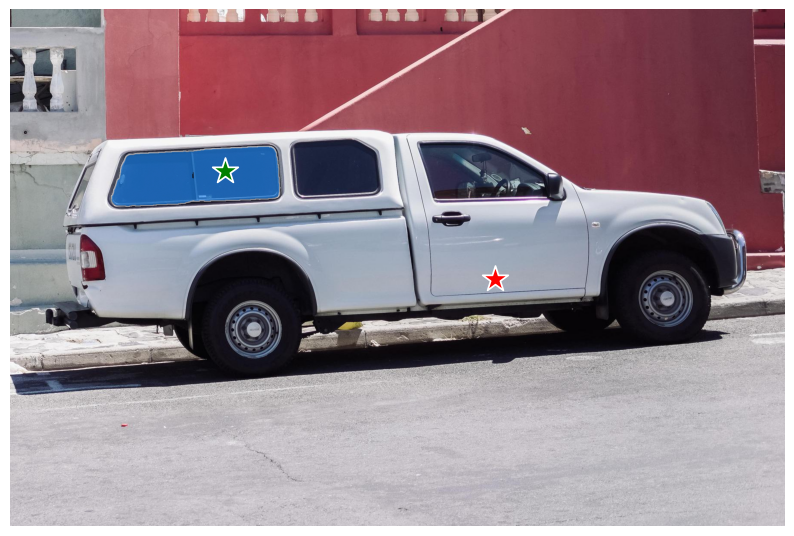

In [23]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)

# バウンディングボックス指定サンプル

In [24]:
input_box = np.array([425, 600, 700, 875])

In [25]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

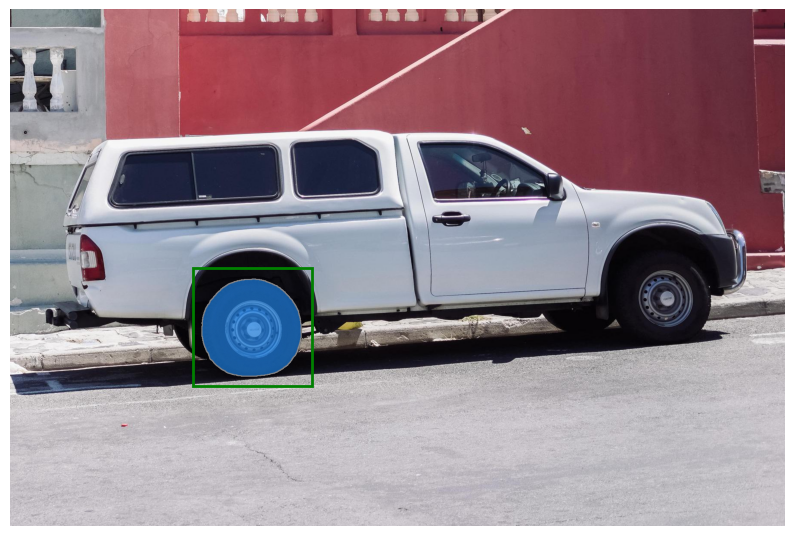

In [26]:
show_masks(image, masks, scores, box_coords=input_box)

# バウンディングボックス指定 + 非対象1点指定サンプル

In [27]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

In [28]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

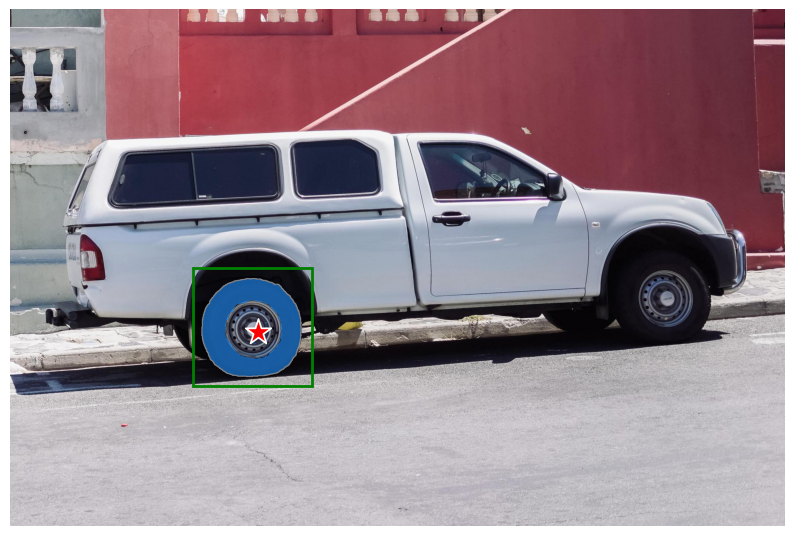

In [29]:
show_masks(image, masks, scores, box_coords=input_box, point_coords=input_point, input_labels=input_label)

# 複数バウンディングボックス指定サンプル

In [30]:
input_boxes = np.array([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
])

In [31]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

In [32]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

(4, 1, 1200, 1800)

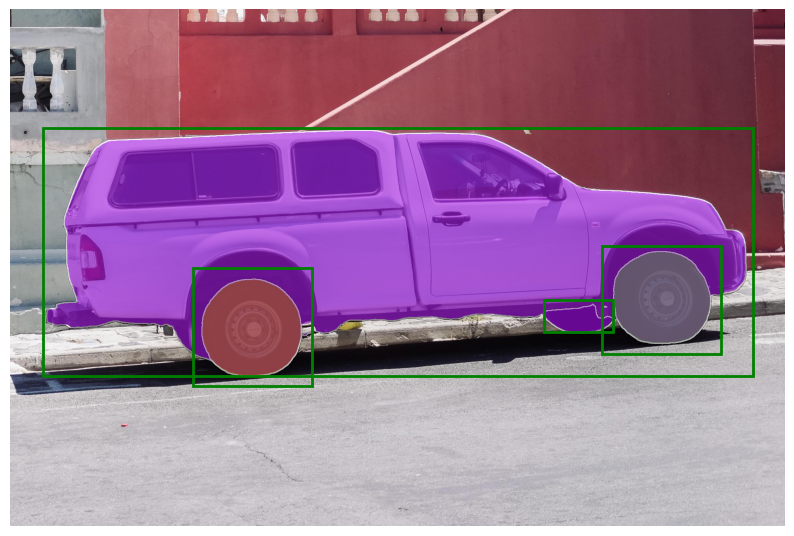

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

# 対象座標 バッチ指定サンプル

In [44]:
image1 = image  # truck.jpg from above
image1_pts = np.array([
    [[500, 375]],
    [[650, 750]]
    ]) # Bx1x2 where B corresponds to number of objects
image1_labels = np.array([[1], [1]])

image2_pts = np.array([
    [[400, 300]],
    [[630, 300]],
])
image2_labels = np.array([[1], [1]])

pts_batch = [image1_pts, image2_pts]
labels_batch = [image1_labels, image2_labels]

In [47]:
masks_batch, scores_batch, _ = predictor.predict_batch(pts_batch, labels_batch, box_batch=None, multimask_output=True)

# Select the best single mask per object
best_masks = []
for masks, scores in zip(masks_batch,scores_batch):
    best_masks.append(masks[range(len(masks)), np.argmax(scores, axis=-1)])

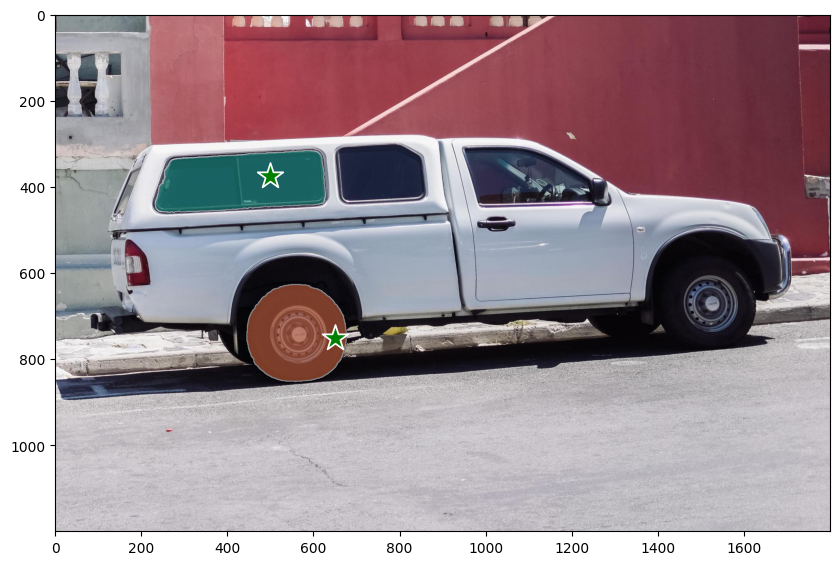

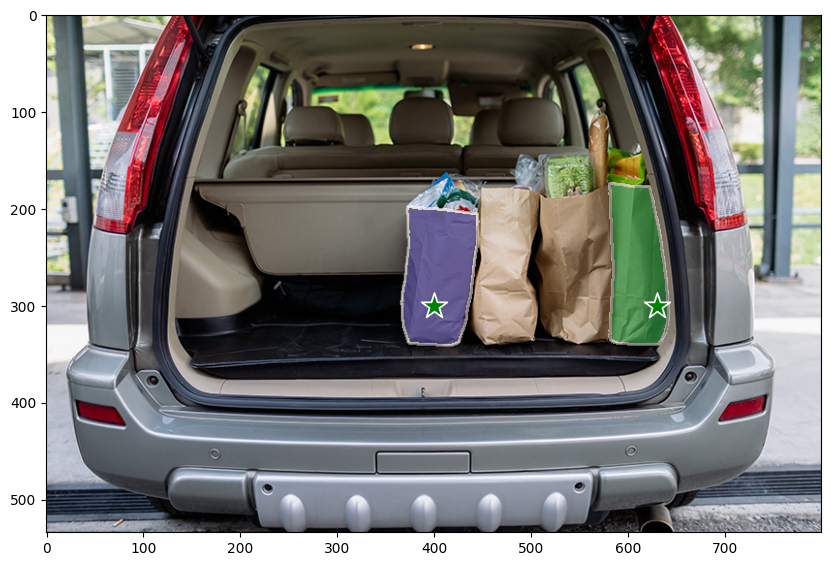

In [48]:
for image, points, labels, masks in zip(img_batch, pts_batch, labels_batch, best_masks):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask, plt.gca(), random_color=True)
    show_points(points, labels, plt.gca())

# バウンディングボックス バッチ指定サンプル

In [39]:
image1 = image  # truck.jpg from above
image1_boxes = np.array([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
])

image2 = Image.open('notebooks/images/groceries.jpg')
image2 = np.array(image2.convert("RGB"))
image2_boxes = np.array([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
])

img_batch = [image1, image2]
boxes_batch = [image1_boxes, image2_boxes]

In [40]:
predictor.set_image_batch(img_batch)

In [41]:
masks_batch, scores_batch, _ = predictor.predict_batch(
    None,
    None,
    box_batch=boxes_batch,
    multimask_output=False
)

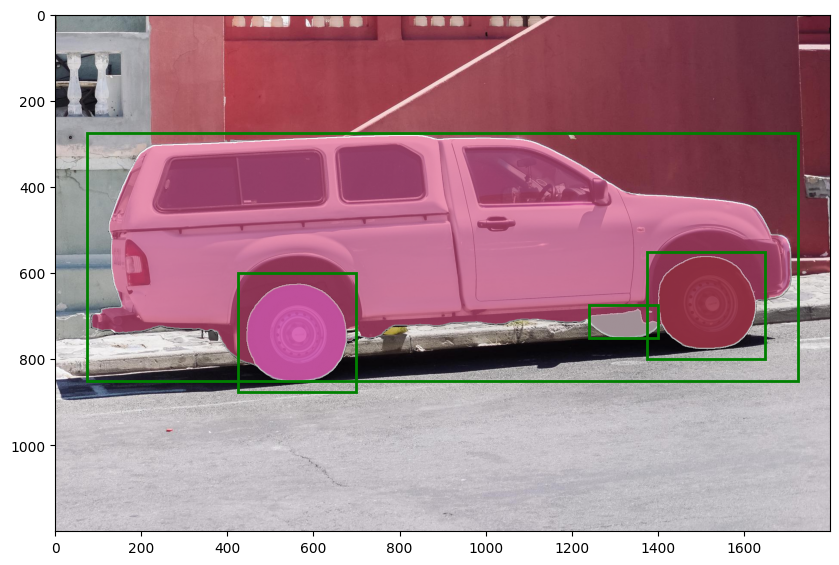

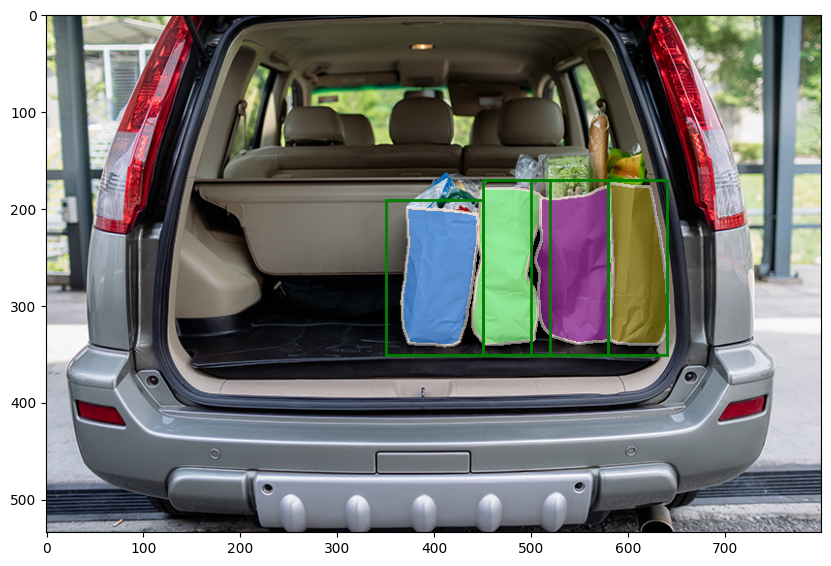

In [42]:
for image, boxes, masks in zip(img_batch, boxes_batch, masks_batch):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask.squeeze(0), plt.gca(), random_color=True)
    for box in boxes:
        show_box(box, plt.gca())